### 검색

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 67.5 MB/s eta 0:00:00


## kandinsky 라이브러리

In [3]:
import faiss
import json
import  torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd

import os
import io
import requests
from PIL import Image
import PIL
from google.colab import files
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

In [4]:
# 임베딩 CLIP 모델 정보
model_name = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)


# text 임베딩 벡터 반환

# 텍스트를 텐서로 바꾸기
def encode_text(text): # -> 출력으로 임베딩한 후 정규화까지 한 텍스트 데이터 벡터
    inputs = processor(text=[text], return_tensors="pt")

    # 텐서로 바꾼 후 임베딩 벡터로 변환
    with torch.no_grad():
        text_features = clip_model.get_text_features(**inputs)

    # 벡터로 바꾼 후 정규화 와이??
    text_features = torch.nn.functional.normalize(text_features, p=2, dim=-1) #정규화

    return text_features.cpu().numpy().astype("float32")

# 검색
def search_similar_images(text, image_index, top_k=5):
    text_vec = encode_text(text)
    # DB에 있는 이미지 벡터랑 텍스트 벡터 사이의 유사도로 거리랑 이미지(DB) 위치 출력
    distances, indices = image_index.search(text_vec, top_k)

    # 개별 벡터 가져오기
    image_embed_vectors = []
    for x in range(len(indices)):
      for i in indices[x]:  # 이차원 배열이므로 첫 번째 row에서 가져오기, (1,topk) 인데 1은 텍스트 쿼리가 하나임을 의미한다.
        vec = np.zeros((image_index.d,), dtype=np.float32)  # 빈 벡터 생성, image_index.d는 저장된 이미지 벡터의 차원 수를 의미!
        image_index.reconstruct(int(i), vec)  # 특정 ID의 벡터 복원, vec라는 객체에 벡터를 저장
        image_embed_vectors.append(vec) # 저장, 리스트의 형태로 이미지(DB)를 차례차례 저장

      # 리스트를 텐서로 변환하면 오류가 발생할 수 있어서, 배열로 변환하여 배치형태로 만든 후, 텐서 형태로 변환한다.
    image_embed = torch.tensor(np.array(image_embed_vectors), dtype=torch.float32)


    return image_embed, distances # 이미지를 벡터 형태로, 거리

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

## 입력 이미지 받기

In [6]:
# 이미지 입력 받기

upload_dir = "/content/uploads"
os.makedirs(upload_dir, exist_ok=True)

# 업로드된 이미지 경로 저장
uploaded_image_paths = []

# Colab에서 이미지 파일 업로드 및 저장
def upload_images():
    uploaded_files = files.upload()
    for file_name in uploaded_files.keys():
        file_path = os.path.join("/content", file_name)  # 기본 업로드 경로
        move_path = os.path.join(upload_dir, file_name)  # 사용자 지정 디렉토리

        # 파일을 원하는 디렉토리로 이동
        os.rename(file_path, move_path)

        uploaded_image_paths.append(move_path)
        print(f"save image : {move_path}")


# 버튼 설정
upload_button = widgets.Button(description="이미지 업로드")

# 클릭 시 실행
def on_upload_clicked(b):
    upload_images()


upload_button.on_click(on_upload_clicked)

# 출력
display(upload_button)


Button(description='이미지 업로드', style=ButtonStyle())

Saving 목줄.jpg to 목줄.jpg
save image : /content/uploads/목줄.jpg


## DB 불러오기

In [5]:
# DB 설정
#faiss_index_filename = "/content/faiss_index_vitL14.index"  # FAISS 벡터 DB 파일 경로 # 풍경 이미지
faiss_index_filename = "/content/drive/MyDrive/멀티모달프로젝트/faiss_DB/dog_ad.index"
# FAISS 벡터 DB 파일 경로 # 강아지, 고양이 이미지


# FAISS 인덱스 로드
db_index = faiss.read_index(faiss_index_filename)

# 우선은 서브쿼리의 효과 확인을 위해 문장은 정확하게 직접 작성해서 나눠보았어요

- 입력쿼리와 서브쿼리를 각각 작성

In [7]:
# 텍스트 입력
query_text = "A cute dog running outdoors with a red collar on its neck, with emphasis on the collar, in an photorealistic style"
divided_query_texts = ["A cute dog is running outdoors.","The cute dog is wearing a red collar on its neck.",
"The focus is on the red collar in an photorealistic style."]

#divided_query_texts = [query_text]

# 서브 쿼리로 분할

print(divided_query_texts)

# input 이미지 임베딩 + 정규화

input_images = [Image.open(path).convert("RGB") for path in uploaded_image_paths] # 입력 이미지 리스트


top_k = 3 # 최근접 이웃 개수



['A cute dog is running outdoors.', 'The cute dog is wearing a red collar on its neck.', 'The focus is on the red collar in an photorealistic style.']


# 단일쿼리로 DB를 검색할지, 서브쿼리를 이용하여 검색할지 선택하여서 하나의 셀만 실행시켜주세요

## 단일 쿼리로 DB 검색 (선택지1)

In [10]:
similar_images_emb, distances = search_similar_images(query_text, db_index, top_k=top_k)
print(similar_images_emb)
print(distances)
weights = np.array(distances[0]) # 거리 저장
normalized_weights = weights / np.sum(weights)
top_k_w = normalized_weights.tolist()
print(top_k_w)

concatenated_tensor=similar_images_emb
normalized_weight_list = top_k_w

tensor([[ 0.5176,  1.2617,  0.0914,  ..., -0.2578,  0.4115,  0.3655],
        [ 0.5176,  1.2617,  0.0914,  ..., -0.2578,  0.4115,  0.3655],
        [ 0.8685, -0.3355, -0.3191,  ...,  0.6661,  0.0806,  0.2022]])
[[257.39133 257.39133 257.44113]]
[0.33331185579299927, 0.33331185579299927, 0.33337634801864624]


## 여러 쿼리로 DB 검색 (선택지2)

In [13]:
# 유사한 이미지 벡터 검색
list_similar_images_emb = []
list_distances = []
list_top_k_w = []

for query_text in divided_query_texts:
  similar_images_emb, distances = search_similar_images(query_text, db_index, top_k=top_k)
  list_similar_images_emb.append(similar_images_emb)
  list_distances.append(distances)

  # top_k 이미지에 대한 가중치 계산

  # 해당 부분 설정은 자유 -> 다양하게 바꿀 수 있음
  weights = np.array(distances[0]) # 거리 저장

  # 정규화 (합이 1이 되도록)
  normalized_weights = weights / np.sum(weights)
  top_k_w = normalized_weights.tolist() # 가중치를 list 타입으로 받음
  list_top_k_w.append(top_k_w)
  print(top_k_w)

# 사이즈 조정
concatenated_tensor = torch.cat(list_similar_images_emb, dim=0)
print(concatenated_tensor.shape)
merged_list = [item for sublist in list_top_k_w for item in sublist]  # 평탄화
merged_list_2d = np.array(merged_list).reshape(-1, 1)  # (9, k) 형태 변환
weight_list = merged_list_2d.flatten().tolist()
normalized_weight_list = weight_list / np.sum(weight_list)
print(merged_list_2d.shape)

[0.33280161023139954, 0.33280161023139954, 0.33439671993255615]
[0.33301419019699097, 0.33301419019699097, 0.33397161960601807]
[0.3328411281108856, 0.3328411281108856, 0.33431771397590637]
torch.Size([9, 768])
(9, 1)


### 생성

### 수정된 라이브러리 불러오기

In [8]:
### 라이브러리 파일 교체 -> 수정된 모델 불러오기

import os
from google.colab import files

# 교체할 파일 경로
file_path = "/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/kandinsky/pipeline_kandinsky_prior.py"

# 파일 업로드
uploaded_files = files.upload()

# 업로드된 파일 처리
for file_name in uploaded_files.keys():
    # 업로드된 파일이 Python 파일인지 확인
    if file_name.endswith(".py"):
        upload_file_path = os.path.join("/content", file_name)  # Colab 기본 업로드 경로

        # 파일을 diffusers 경로로 이동하여 덮어쓰기
        os.rename(upload_file_path, file_path)

        print(f"업로드 완료")
    else:
        print(f"ERROR")



Saving pipeline_kandinsky_prior_s.py to pipeline_kandinsky_prior_s.py
업로드 완료


### 수정된 라이브러리를 통해 생성 모델 불러오기

In [9]:
from diffusers import KandinskyPriorPipeline, KandinskyPipeline

# 모델 불러오기
pipe_prior = KandinskyPriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-1-prior", torch_dtype=torch.float16
)
pipe_prior.to("cuda")


pipe = KandinskyPipeline.from_pretrained("kandinsky-community/kandinsky-2-1", torch_dtype=torch.float16)
pipe.to("cuda")


model_index.json:   0%|          | 0.00/500 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

prior%2Fconfig.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

(…)age_processor%2Fpreprocessor_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

image_encoder%2Fconfig.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/626 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.09G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/495M [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/767 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/318 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/271M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer%2Ftokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

movq%2Fconfig.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You are using a model of type xlm-roberta to instantiate a model of type M-CLIP. This is not supported for all configurations of models and can yield errors.


KandinskyPipeline {
  "_class_name": "KandinskyPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "kandinsky-community/kandinsky-2-1",
  "movq": [
    "diffusers",
    "VQModel"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "kandinsky",
    "MultilingualCLIP"
  ],
  "tokenizer": [
    "transformers",
    "XLMRobertaTokenizerFast"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ]
}

# 실제 생성을 진행합니다.
# 원하시는 케이스의 셀을 실행시켜 주세요

## 선택지1
- 입력텍스트 : 단일쿼리
- DB 검색 : 앞선 선택지

  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
add top k image
11
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

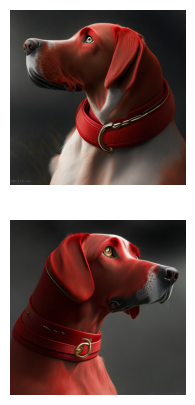

In [15]:
# 텍스트 가중치
query_text_w = 0.9
cond_image_w = 0.3
DB_weight = 0.3
normalized_weight_list = [x * DB_weight for x in normalized_weight_list]
# 생성 이미지 개수
num_images_per_prompt = 2

# image_text 컨디션 리스트, input_images는 입력된 이미지를 리스트로 저장한 것
# 둘다 벡터X raw data -> 위에서 텍스트 임베딩한거는 유사한 이미지 찾기 위한 수단


images_texts = [query_text] + input_images

# 가중치 설정
weights = [query_text_w] +[cond_image_w/(len(input_images)) for _ in input_images]

# 이 뒷부분 [cond_image_w/(len(input_images)) for _ in input_images] 영역은
# 이미지 개수에 맞게 직접 설정 가능 [0.3, 0.5] 이런 식


# 이 뒷부분 [cond_image_w/(len(input_images)) for _ in input_images] 영역은
# 이미지 개수에 맞게 직접 설정 가능 [0.3, 0.5] 이런 식

prompt = query_text
prior_out = pipe_prior.interpolate(images_texts,
                                   weights,
                                   search_k=True,
                                   top_k_image = concatenated_tensor.to("cuda", dtype=torch.float16),
                                   top_k_w =normalized_weight_list)
# 입력(텍스트 + 이미지) + Retrieve 이미지(DB)를 하나의 벡터로 묶었다.

"""
변수 설명
image_text : 이미지+텍스트 컨디션 리스트 -> 우리가 입력한 것, Retrieve 된 것 X
weight : 이미지+텍스트 컨디션 가중치
search_k : 최근접 이미지 k를 삽입할 것인지 여부 (bool)
top_k_image : 찾은 최근접 이미지 벡터, clip으로 embedding된 것, faiss 상태
top_k_w : 최근접 이미지 가중치
"""


new_image_add = pipe(prompt, **prior_out, height=768, width=768, num_images_per_prompt=num_images_per_prompt).images
#prior_out은 image_embs + negative image embs로 구성됨
# 여기서도  매개변수 지정 가능
"""
num_images_per_prompt : 생성할 이미지 개수
guidance_scale : prompt 집중 정도
"""
if num_images_per_prompt > 1:
  plt.figure(figsize=(10,5))
  for i in range(len(new_image_add)):
    plt.subplot(2, round(len(new_image_add)/2), i+1)
    plt.imshow(new_image_add[i])
    plt.axis('off')
  plt.show()
else:
  plt.imshow(new_image_add)
  plt.axis('off')
  plt.show()



## 선택지2
- 입력 텍스트 : 서브쿼리
- DB 검색 : 앞선 선택지

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
add top k image
13
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

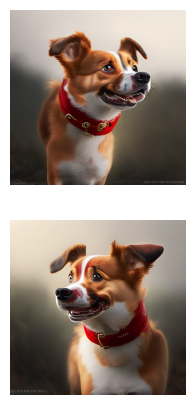

In [14]:
# 텍스트 가중치
cond_image_w = 0.3
DB_weight = 0.3
normalized_weight_list = [x * DB_weight for x in normalized_weight_list]
# 생성 이미지 개수
num_images_per_prompt = 2

# image_text 컨디션 리스트, input_images는 입력된 이미지를 리스트로 저장한 것
# 둘다 벡터X raw data -> 위에서 텍스트 임베딩한거는 유사한 이미지 찾기 위한 수단


images_texts = divided_query_texts + input_images




# 가중치 설정
#weights = [query_text_w] +[cond_image_w/(len(input_images)) for _ in input_images]
weights = [0.5, 0.3, 0.3]  +[cond_image_w/(len(input_images)) for _ in input_images]

# 이 뒷부분 [cond_image_w/(len(input_images)) for _ in input_images] 영역은
# 이미지 개수에 맞게 직접 설정 가능 [0.3, 0.5] 이런 식


# 이 뒷부분 [cond_image_w/(len(input_images)) for _ in input_images] 영역은
# 이미지 개수에 맞게 직접 설정 가능 [0.3, 0.5] 이런 식

prompt = query_text
prior_out = pipe_prior.interpolate(images_texts,
                                   weights,
                                   search_k=True,
                                   top_k_image = concatenated_tensor.to("cuda", dtype=torch.float16),
                                   top_k_w =normalized_weight_list)
# 입력(텍스트 + 이미지) + Retrieve 이미지(DB)를 하나의 벡터로 묶었다.

"""
변수 설명
image_text : 이미지+텍스트 컨디션 리스트 -> 우리가 입력한 것, Retrieve 된 것 X
weight : 이미지+텍스트 컨디션 가중치
search_k : 최근접 이미지 k를 삽입할 것인지 여부 (bool)
top_k_image : 찾은 최근접 이미지 벡터, clip으로 embedding된 것, faiss 상태
top_k_w : 최근접 이미지 가중치
"""


new_image_add = pipe(prompt, **prior_out, height=768, width=768, num_images_per_prompt=num_images_per_prompt).images
#prior_out은 image_embs + negative image embs로 구성됨
# 여기서도  매개변수 지정 가능
"""
num_images_per_prompt : 생성할 이미지 개수
guidance_scale : prompt 집중 정도
"""
if num_images_per_prompt > 1:
  plt.figure(figsize=(10,5))
  for i in range(len(new_image_add)):
    plt.subplot(2, round(len(new_image_add)/2), i+1)
    plt.imshow(new_image_add[i])
    plt.axis('off')
  plt.show()
else:
  plt.imshow(new_image_add)
  plt.axis('off')
  plt.show()



In [ ]:
# 생성 이미지 개수
num_images_per_prompt = 2

prompt = query_text

negative_prompt = "low quality, bad quality" # negative 프롬프트 포함은 선택
image_embeds, negative_image_embeds = pipe_prior(prompt, negative_prompt).to_tuple()

new_image_onlytext = pipe(prompt, image_embeds=image_embeds, negative_image_embeds=negative_image_embeds, height=768, width=768, num_images_per_prompt=num_images_per_prompt).images

if num_images_per_prompt > 1:
  plt.figure(figsize=(10,5))
  for i in range(len(new_image_onlytext)):
    plt.subplot(2, round(len(new_image_onlytext)/2), i+1)
    plt.imshow(new_image_onlytext[i])
    plt.axis('off')
    plt.show()
else:
  plt.imshow(new_image_onlytext)
  plt.axis('off')
  plt.show()

